In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import os
import matplotlib.pyplot as plt
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score, silhouette_score

RANDOM_STATE = 42
RESULTS_FOLDER = 'results/'
DATA_PATH = 'data/GSE239626/MTX'

c:\Users\giuli\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Import data

In [2]:
adata = sc.read_10x_mtx(
    DATA_PATH,
    var_names='gene_symbols',
    gex_only=False,
    cache=True)

adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 72317 × 36636
    var: 'gene_ids', 'feature_types'

Normalize data

In [3]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

Data correlation and variance

In [14]:
matrix = adata[:, adata.var['feature_types'] == 'Antibody Capture'].X
matrix = adata[:, adata.var['feature_types'] == 'Antibody Capture'].X.todense()

In [23]:
labels = adata[:, adata.var['feature_types'] == 'Antibody Capture'].var['gene_ids'].values

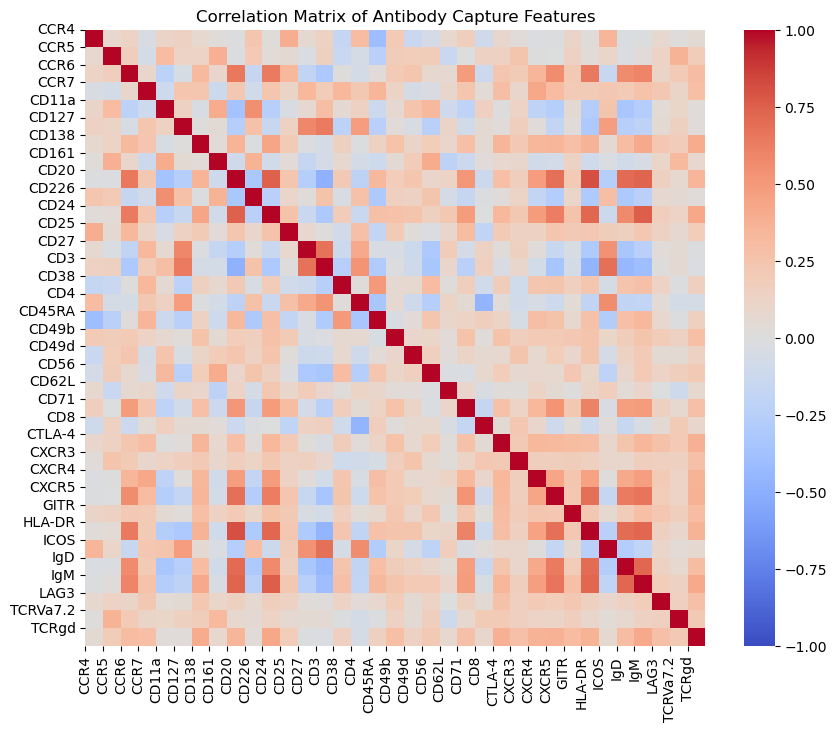

In [28]:
correlation_matrix = np.corrcoef(matrix, rowvar=False)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.xticks(np.arange(len(labels)), labels, rotation=90)
plt.yticks(np.arange(len(labels)), labels, rotation=0)
plt.title('Correlation Matrix of Antibody Capture Features')
plt.show()

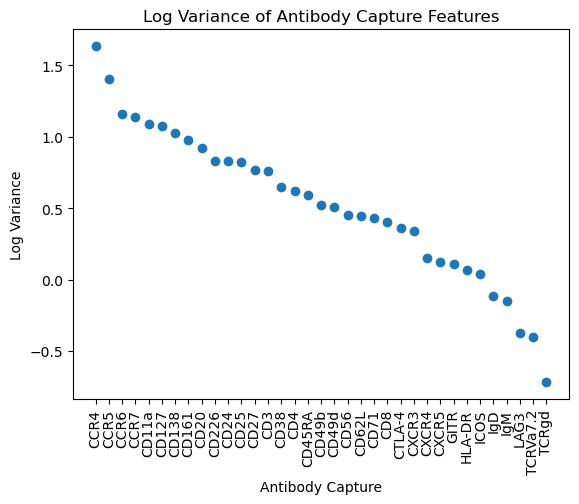

In [24]:
neg_variances = np.sort(-np.var(matrix, axis=0))
labels_index = np.argsort(-np.var(matrix, axis=0))
sorted_log_variances = [np.log(-i) for i in neg_variances.T][:2000]
plt.scatter([i for i in range(len(sorted_log_variances))], sorted_log_variances)
plt.xlabel('Antibody Capture')
plt.xticks(np.arange(len(sorted_log_variances)), labels, rotation=90)
plt.ylabel('Log Variance')
plt.title('Log Variance of Antibody Capture Features')
plt.show()

Select only 'Antibody Capture'

In [6]:
adata = adata[:, adata.var['feature_types'] == 'Antibody Capture']

### PCA

In [7]:
sc.tl.pca(
    adata,
    svd_solver='arpack',
    n_comps=30,
    random_state=RANDOM_STATE
    )

c:\Users\giuli\anaconda3\lib\site-packages\scanpy\preprocessing\_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca


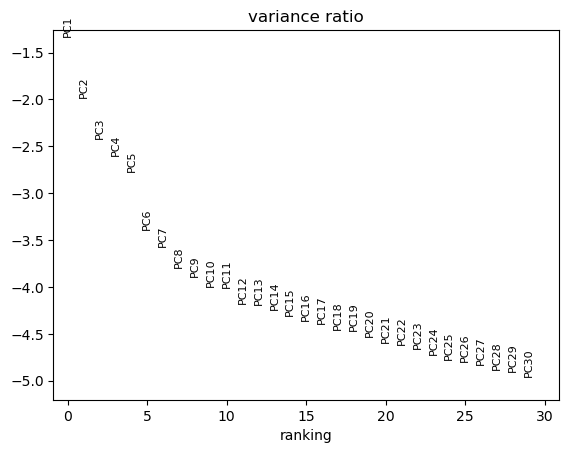

In [8]:
sc.pl.pca_variance_ratio(adata, log=True)

In [9]:
adata.obsm['X_pca'].shape

(72317, 30)

In [10]:
adata.varm['PCs'].shape

(35, 30)

### Clustering

In [11]:
pca_dims_list = [5, 6, 7] # non influente, scegliere bassa
n_neighbors_list = [5, 10] # più alto, meglio è
resolution_list = [0.5, 0.8, 1] # questa è da studiare

clustering_score_df = pd.DataFrame(columns=['n_neighbors', 'pca_dim', 'resolution', 'silhouette_score'
    'calinski_harabasz_score', 'davies_bouldin_score'])

In [12]:
def model_selection_loop(adata, pca_dims_list, n_neighbors_list, resolution_list, clustering_score_df):
    for pca_dim in pca_dims_list:
        for n_neighbors in n_neighbors_list:
            for resolution in resolution_list:
                print('n_neighbors:', n_neighbors, 'pca_dim:', pca_dim, 'resolution:', resolution)
                sc.pp.neighbors(
                    adata,
                    n_neighbors=n_neighbors,
                    n_pcs=pca_dim,
                    knn=True,
                    metric='euclidean', # 'correlation'
                    random_state=RANDOM_STATE
                    )

                sc.tl.umap(
                    adata,
                    n_components=2, # number of dimensions of the UMAP embedding
                    method='umap',
                    random_state=RANDOM_STATE,
                    )

                sc.tl.leiden(
                    adata,
                    resolution=resolution, # controlling the coarseness of the clustering: higher values lead to more clusters
                    directed=False, # undirect graph
                    n_iterations=-1, # until convergence of the clustering
                    flavor='leidenalg', # 'leidenalg', 'ipgraph'
                    random_state=RANDOM_STATE,
                    )

                # compute score
                print('Computing score...')
                silhouette = silhouette_score(adata.X, adata.obs['leiden'], metric='euclidean', random_state=RANDOM_STATE)
                calinski_harabasz = calinski_harabasz_score(adata.X.toarray(), adata.obs['leiden'])
                davies_bouldin = davies_bouldin_score(adata.X.toarray(), adata.obs['leiden'])

                score_dict = {
                    'n_neighbors': n_neighbors,
                    'pca_dim': pca_dim,
                    'resolution': resolution,
                    'silhouette_score': silhouette,
                    'calinski_harabasz_score': calinski_harabasz,
                    'davies_bouldin_score': davies_bouldin
                }
                clustering_score_df = pd.concat([clustering_score_df, pd.DataFrame(score_dict, index=[0])], ignore_index=True)

    return clustering_score_df

In [13]:
if os.path.exists(RESULTS_FOLDER+'clustering_score.csv'):
    clustering_score_df = pd.read_csv(RESULTS_FOLDER+'clustering_score.csv', index_col=0)
else:
    clustering_score_df = model_selection_loop(adata, pca_dims_list, n_neighbors_list, resolution_list, clustering_score_df)
    clustering_score_df.to_csv(RESULTS_FOLDER+'clustering_score.csv')

In [14]:
clustering_score_df

,n_neighbors,pca_dim,resolution,silhouette_score,calinski_harabasz_score,davies_bouldin_score
0,5,5,0.5,0.099705,3937.403478,1.973239
1,5,5,0.8,0.063565,3114.038234,2.126113
2,5,5,1.0,0.068354,2943.284598,2.230839
3,10,5,0.5,0.125504,4947.515582,2.033821
4,10,5,0.8,0.108213,4214.301099,2.226137
5,10,5,1.0,0.082922,3850.635724,2.195084
6,5,6,0.5,0.099705,3937.403478,1.973239
7,5,6,0.8,0.063565,3114.038234,2.126113
8,5,6,1.0,0.068354,2943.284598,2.230839
9,10,6,0.5,0.125504,4947.515582,2.033821


In [15]:
def visualize_score(score_values, labels, score_name):
    sorted_data = sorted(zip(score_values, labels))
    score_values, labels = zip(*sorted_data)

    plt.figure(figsize=(10, 3))
    plt.plot(range(len(labels)), score_values, 'o-')
    plt.title(score_name)
    plt.xlabel('Model')
    plt.xticks(range(len(labels)), labels)
    plt.show()

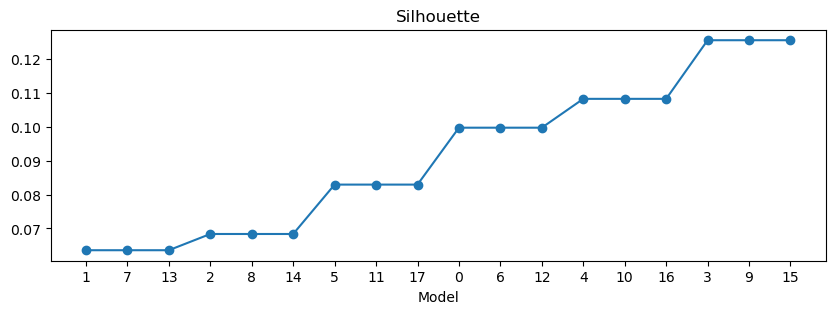

In [16]:
visualize_score(clustering_score_df['silhouette_score'], clustering_score_df.index, 'Silhouette')

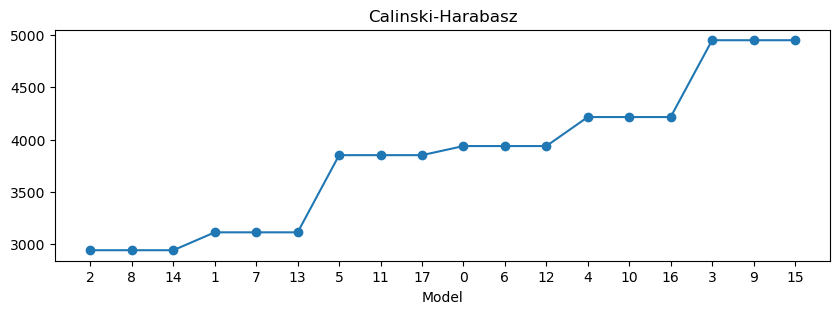

In [17]:
visualize_score(clustering_score_df['calinski_harabasz_score'], clustering_score_df.index, 'Calinski-Harabasz')

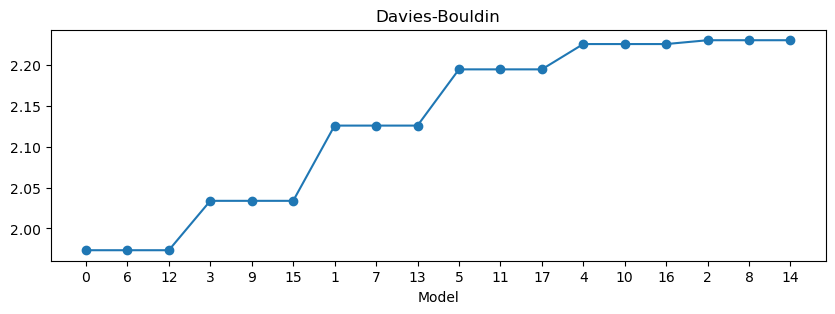

In [18]:
visualize_score(clustering_score_df['davies_bouldin_score'], clustering_score_df.index, 'Davies-Bouldin')

### Best model

In [19]:
# extrapolate best param based on silhouette score
row = clustering_score_df[clustering_score_df['silhouette_score'] == clustering_score_df['silhouette_score'].max()]
row

,n_neighbors,pca_dim,resolution,silhouette_score,calinski_harabasz_score,davies_bouldin_score
3,10,5,0.5,0.125504,4947.515582,2.033821
9,10,6,0.5,0.125504,4947.515582,2.033821
15,10,7,0.5,0.125504,4947.515582,2.033821


In [20]:
n_neighbors = row['n_neighbors'].values[0]
pca_dim = row['pca_dim'].values[0]
resolution = row['resolution'].values[0]

In [21]:
print('Best model:')
print('n_neighbors:', n_neighbors, 'pca_dim:', pca_dim, 'resolution:', resolution)

Best model:
n_neighbors: 10 pca_dim: 5 resolution: 0.5


In [22]:
sc.pp.neighbors(
    adata,
    n_neighbors=n_neighbors,
    n_pcs=pca_dim,
    knn=True,
    metric='euclidean',
    random_state=RANDOM_STATE
    )

sc.tl.umap(
    adata,
    n_components=2, # number of dimensions of the UMAP embedding
    method='umap',
    random_state=RANDOM_STATE,
    )

sc.tl.leiden(
    adata,
    resolution=resolution,
    directed=False,
    n_iterations=-1,
    flavor='leidenalg',
    random_state=RANDOM_STATE,
    )

print('Silhoutte score:', silhouette_score(adata.X, adata.obs['leiden'], metric='euclidean', random_state=RANDOM_STATE), 
    'Calinski-Harabasz score:', calinski_harabasz_score(adata.X.toarray(), adata.obs['leiden']),
    'Davies-Bouldin score:', davies_bouldin_score(adata.X.toarray(), adata.obs['leiden']))

c:\Users\giuli\anaconda3\lib\site-packages\scipy\sparse\_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
C:\Users\giuli\AppData\Local\Temp\ipykernel_3008\1138792998.py:17: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(


Silhoutte score: 0.12550436 Calinski-Harabasz score: 4947.515581968791 Davies-Bouldin score: 2.03382063913082


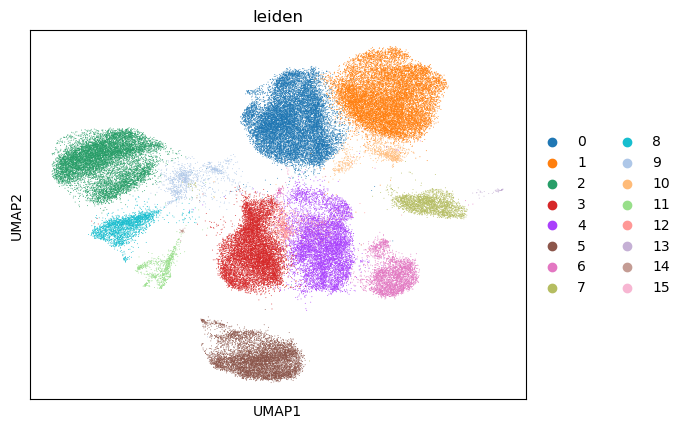

In [23]:
sc.pl.umap(adata, color=['leiden']) # leiden clustering on gene count

In [24]:
adata.obs['leiden'].to_csv(RESULTS_FOLDER+'cluster_labels.csv')

### Plot

In [25]:
import altair as alt
from functools import partial

alt.renderers.enable("png")
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

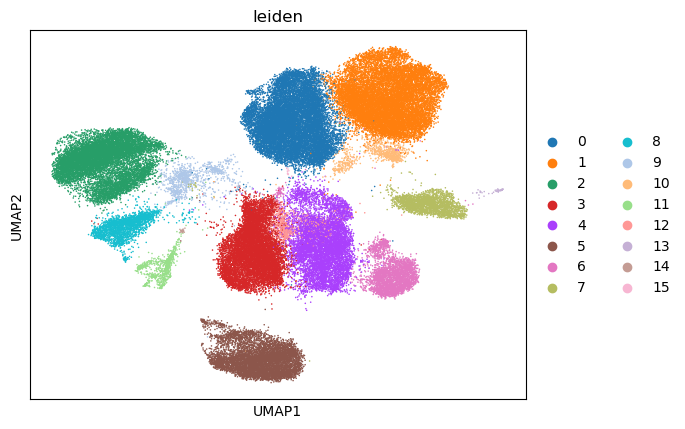

In [26]:
sc.pl.umap(adata, color=["leiden"], size=5)

In [27]:
protein = adata

In [28]:
adata = sc.read_10x_mtx(
    DATA_PATH,
    var_names='gene_symbols',
    gex_only=False,
    cache=True)

adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 72317 × 36636
    var: 'gene_ids', 'feature_types'

In [29]:
#protein = adata[:, adata.var["feature_types"] == "Antibody Capture"].copy()
rna = adata[:, adata.var["feature_types"] == "Gene Expression"].copy()

In [30]:
rna

AnnData object with n_obs × n_vars = 72317 × 36601
    var: 'gene_ids', 'feature_types'

In [31]:
sc.pp.neighbors(
    rna,
    n_neighbors=n_neighbors,
    n_pcs=pca_dim,
    knn=True,
    metric='euclidean',
    random_state=RANDOM_STATE
    )

sc.tl.umap(
    rna,
    n_components=2, # number of dimensions of the UMAP embedding
    method='umap',
    random_state=RANDOM_STATE,
    )

sc.tl.leiden(
    rna,
    resolution=resolution,
    directed=False,
    n_iterations=-1,
    flavor='leidenalg',
    random_state=RANDOM_STATE,
    )

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [32]:
rna.obsm["protein"] = protein.to_df()
rna.obsm["protein_umap"] = protein.obsm["X_umap"]
rna.obs["protein_leiden"] = protein.obs["leiden"]
rna.obsp["rna_connectivities"] = rna.obsp["connectivities"].copy()
rna.obsp["protein_connectivities"] = protein.obsp["connectivities"]

In [33]:
def join_graphs_max(g1: "sparse.spmatrix", g2: "sparse.spmatrix"):
    """Take the maximum edge value from each graph."""
    out = g1.copy()
    mask = g1 < g2
    out[mask] = g2[mask]

    return out

rna.obsp["connectivities"] = join_graphs_max(rna.obsp["rna_connectivities"], rna.obsp["protein_connectivities"])
sc.tl.leiden(rna, key_added="joint_leiden")
sc.tl.umap(rna)

c:\Users\giuli\anaconda3\lib\site-packages\scipy\sparse\_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


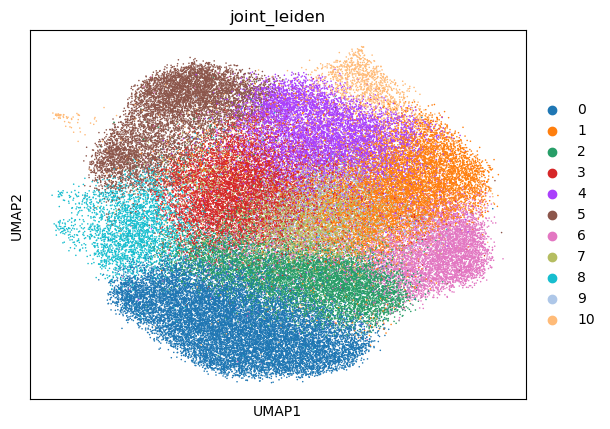

In [34]:
sc.pl.umap(rna, color=["joint_leiden"], size=5)

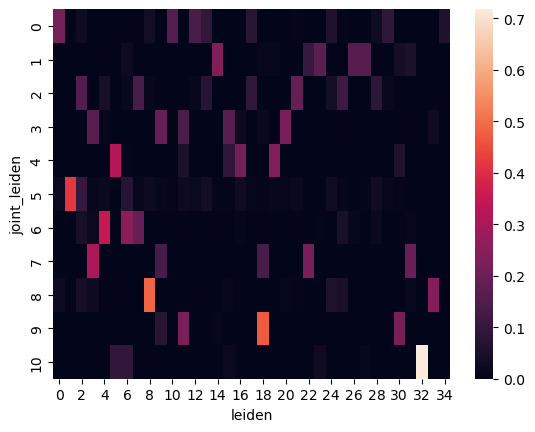

In [35]:
sns.heatmap(pd.crosstab(rna.obs["joint_leiden"], rna.obs["leiden"], normalize="index"));

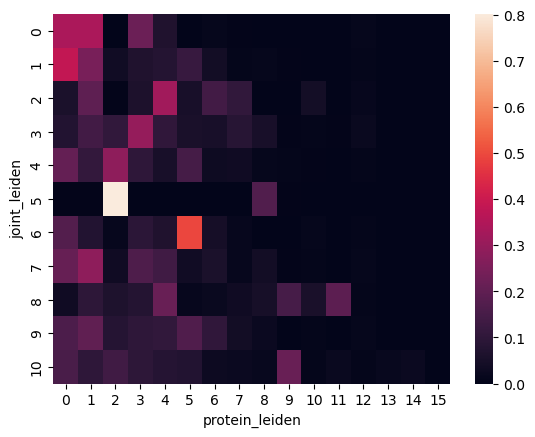

In [36]:
sns.heatmap(pd.crosstab(rna.obs["joint_leiden"], rna.obs["protein_leiden"], normalize="index"));